# 通过量子神经网络对鸢尾花进行分类


## 概述

在之前的案例中，我们介绍了什么是变分量子线路，并通过一个简单的例子体验了如何搭建量子神经网络来解决一个小问题。在本文档中，我们将体验升级，将会介绍如何通过搭建量子神经网络来解决经典机器学习中的问题。我们选取的问题是：监督学习中的鸢尾花分类问题。

问题描述：鸢尾花（iris）数据集是经典机器学习中常用的数据集，该数据集总共包含150个样本（分为3种不同的亚属：山鸢尾（setosa）、杂色鸢尾（versicolor）和维吉尼亚鸢尾（virginica），每个亚属各有50个样本），每个样本包含4个特征，分别为花萼长度（sepal length）、花萼宽度（sepal width）和花瓣长度（petal length）、花瓣宽度（petal width）。

我们选取前100个样本（山鸢尾（setosa）和杂色鸢尾（versicolor）），并随机抽取80个样本作为训练集，通过搭建量子神经网络对量子分类器（Ansatz）进行训练，学习完成后，对剩余的20个样本进行分类测试，期望预测的准确率尽可能高。

思路：我们需要将100个样本进行划分，分成80个训练样本和20个测试样本，根据训练样本的经典数据计算搭建Encoder所需的参数，然后，搭建Encoder，将训练样本的经典数据编码到量子态上，接着，搭建Ansatz，通过搭建的量子神经网络层和MindSpore的算子对Ansatz中的参数进行训练，进而得到最终的分类器，最后，对剩余的20个测试样本进行分类测试，得到预测的准确率。

## 环境准备

首先，我们需要导入鸢尾花的数据集，而在导入该数据集前，我们需要使用sklearn库中的datasets模块，因此读者需要检查是否安装了sklearn库，可执行如下代码进行安装。

In [ ]:
# pylint: disable=W0104
import sys
import mindspore as ms

path = '../'
sys.path.append(path)                                        # 添加自主开发的量子模拟器代码所在路径
ms.set_context(mode=ms.GRAPH_MODE, device_target="Ascend")   # 使用静态图

In [20]:
import numpy as np                                        # 导入numpy库并简写为np
from sklearn import datasets                              # 导入datasets模块，用于加载鸢尾花的数据集

iris_dataset = datasets.load_iris()                       # 加载鸢尾花的数据集，并存在iris_dataset

print(iris_dataset.data.shape)                            # 打印iris_dataset的样本的数据维度
print(iris_dataset.feature_names)                         # 打印iris_dataset的样本的特征名称
print(iris_dataset.target_names)                          # 打印iris_dataset的样本包含的亚属名称
print(iris_dataset.target)                                # 打印iris_dataset的样本的标签的数组
print(iris_dataset.target.shape)                          # 打印iris_dataset的样本的标签的数据维度

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150,)


In [21]:
X = iris_dataset.data[:100, :].astype(np.float32)         # 选取iris_dataset的data的前100个数据，将其数据类型转换为float32，并储存在X中
X_feature_names = iris_dataset.feature_names              # 将iris_dataset的特征名称储存在X_feature_names中
y = iris_dataset.target[:100].astype(int)                 # 选取iris_dataset的target的前100个数据，将其数据类型转换为int，并储存在y中
y_target_names = iris_dataset.target_names[:2]            # 选取iris_dataset的target_names的前2个数据，并储存在y_target_names中

print(X.shape)                                            # 打印样本的数据维度
print(X_feature_names)                                    # 打印样本的特征名称
print(y_target_names)                                     # 打印样本包含的亚属名称
print(y)                                                  # 打印样本的标签的数组
print(y.shape)                                            # 打印样本的标签的数据维度

(100, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(100,)


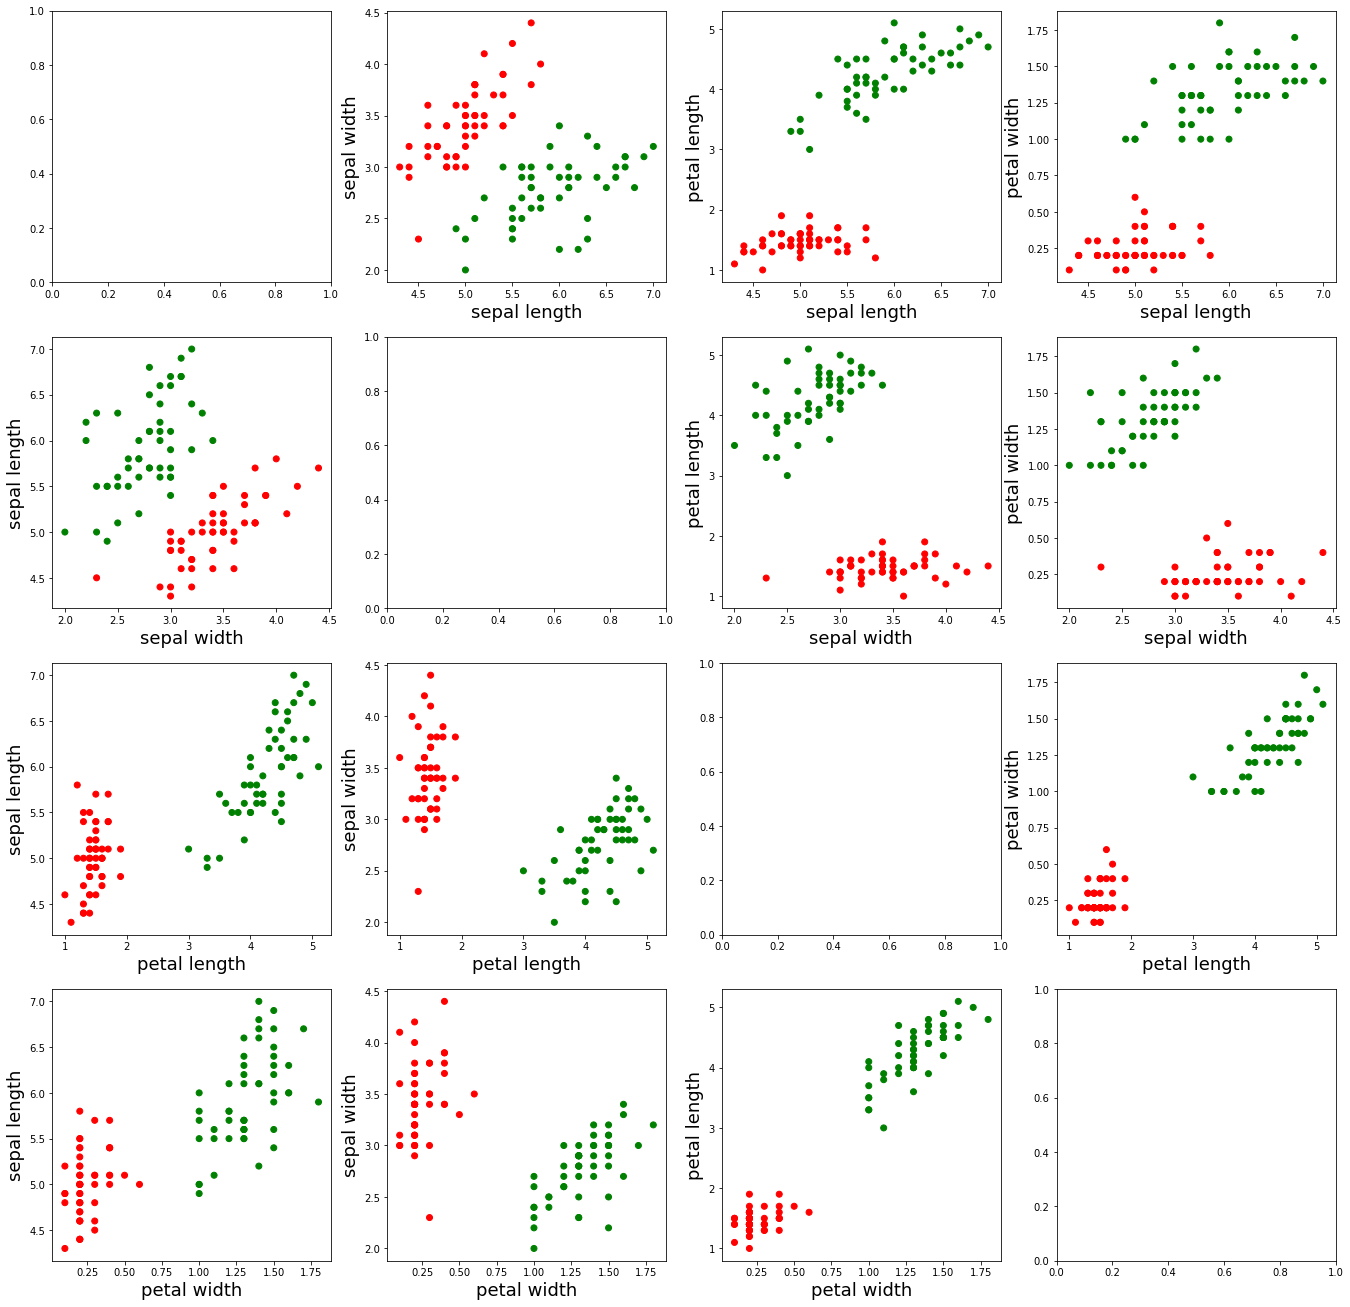

In [22]:
import matplotlib.pyplot as plt                                                           # 导入matplotlib.pyplot模块并简写为plt

feature_name = {0: 'sepal length', 1: 'sepal width', 2: 'petal length', 3: 'petal width'} # 将不同的特征名称分别标记为0,1,2,3
axes = plt.figure(figsize=(23, 23)).subplots(4, 4)                                        # 画出一个大小为23*23的图，包含4*4=16个子图

colormap = {0: 'r', 1: 'g'}                                                               # 将标签为0的样本设为红色，标签为1的样本设为绿色
cvalue = [colormap[i] for i in y]                                                         # 将100个样本对应的标签设置相应的颜色

for i in range(4):
    for j in range(4):
        if i != j:
            ax = axes[i][j]                                                               # 在[i][j]的子图上开始画图
            ax.scatter(X[:, i], X[:, j], c=cvalue)                                        # 画出第[i]个特征和第[j]个特征组成的散点图
            ax.set_xlabel(feature_name[i], fontsize=18)                                   # 设置X轴的名称为第[i]个特征名称，字体大小为22
            ax.set_ylabel(feature_name[j], fontsize=18)                                   # 设置Y轴的名称为第[j]个特征名称，字体大小为22
plt.show()                                                                                # 渲染图像，即呈现图像

In [23]:
alpha = X[:, :3] * X[:, 1:]           # 每一个样本中，利用相邻两个特征值计算出一个参数，即每一个样本会多出3个参数（因为有4个特征值），并储存在alpha中
X = np.append(X, alpha, axis=1)       # 在axis=1的维度上，将alpha的数据值添加到X的特征值中

print(X.shape)                        # 打印此时X的样本的数据维度

(100, 7)


In [24]:
from sklearn.model_selection import train_test_split                                                   # 导入train_test_split函数，用于对数据集进行划分

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True) # 将数据集划分为训练集和测试集

print(X_train.shape)                                                                                   # 打印训练集中样本的数据类型
print(X_test.shape)                                                                                    # 打印测试集中样本的数据类型

(80, 7)
(20, 7)


In [25]:
X_train[0]

array([ 5.        ,  3.5       ,  1.6       ,  0.6       , 17.5       ,
        5.6       ,  0.96000004], dtype=float32)

从上述打印可以看到，此时的训练集有80个样本，测试集有20个样本，每个样本均有7个特征。

说明：

（1）append主要用于为原始数组添加一些值，一般格式如下：np.append(arr, values, axis=None)，arr是需要被添加值的数组，values就是添加到数组arr中的值，axis表示沿着哪个方向；

（2）shuffle=True表示将数据集打乱，每次都会以不同的顺序返回， shuffle就是为了避免数据投入的顺序对网络训练造成影响。增加随机性，提高网络的泛化性能，避免因为有规律的数据出现，导致权重更新时的梯度过于极端，避免最终模型过拟合或欠拟合。

（3）train_test_split是交叉验证中常用的函数，主要用于是从样本中随机地按比例选取训练数据集和测试数据集，一般格式如下：
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size, random_state, shuffle=True)，其中test_size表示测试样本的比例，random_state表示产生随机数的种子，shuffle=True表示将数据集打乱。

## 搭建Encoder

根据图示的量子线路图，我们可以在QuSmoke中搭建Encoder，将经典数据编码到量子态上。

![encoder classification of iris by qnn](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0.0-alpha/docs/mindquantum/docs/source_zh_cn/images/encoder_classification_of_iris_by_qnn.png)

在这里，我们采用的编码方式是IQP编码（Instantaneous Quantum Polynomial encoding），一般来说Encoder的编码方式不固定，可根据问题需要选择不同的编码方式，有时也会根据最后的性能对Encoder进行调整。

Encoder中的参数$\alpha_0,\alpha_1,...,\alpha_6$​​的值，就是用上述数据预处理中得到的7个特征值代入。​

In [27]:
# pylint: disable=W0104
from qusmoke.circuit import Circuit                  # 导入Circuit模块，用于搭建量子线路
from qusmoke.circuit import UN                       # 导入UN模块
from qusmoke.gates import H, X, RZ                   # 导入量子门H, X, RZ

encoder = Circuit()                                  # 初始化量子线路
encoder += UN(H, 4)                                  # H门作用在每1位量子比特
for i in range(4):                                   # i = 0, 1, 2, 3
    encoder += RZ(f'alpha{i}').on(i)                 # RZ(alpha_i)门作用在第i位量子比特
for j in range(3):                                   # j = 0, 1, 2
    # 不支持 X.on(j+1, j)
    encoder += X(j+1, j)                             # X门作用在第j+1位量子比特，受第j位量子比特控制
    encoder += RZ(f'alpha{j+4}').on(j+1)             # RZ(alpha_{j+4})门作用在第0位量子比特
    encoder += X(j+1, j)                             # X门作用在第j+1位量子比特，受第j位量子比特控制

encoder = encoder.no_grad()                          # Encoder作为整个量子神经网络的第一层，不用对编码线路中的梯度求导数，因此加入no_grad()
encoder.summary()                                    # 总结Encoder

=================================Circuit Summary=================================
|Total number of gates  : 17.                                                   |
|Parameter gates        : 7.                                                    |
|with 7 parameters are  :                                                       |
|alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6                        .|
|Number qubit of circuit: 4                                                     |


从对Encoder的Summary中可以看到，该量子线路由17个量子门组成，其中有7个含参量子门且参数为$\alpha_0,\alpha_1,...,\alpha_6$，该量子线路调控的量子比特数为4。

说明：

UN模块用于将量子门映射到不同的目标量子比特和控制量子比特，一般格式如下：`qusmoke.UN(gate, obj_qubits)`，括号中的`gate`是我们需要执行的量子门，`obj_qubits`是需要执行该量子门的目标量子比特。若每个量子比特位执行同一个非参数量子门，则可以直接写出UN(gate, N)，N表示量子比特个数。

## 搭建Ansatz

根据图示的量子线路图，我们可以在QuSmoke中搭建Ansatz。

![ansatz classification of iris by qnn](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/ansatz_classification_of_iris_by_qnn.png)

与Encoder一样，Ansatz的编码方式也不固定，我们可以尝试不同的编码方式来测试最后的结果。

在这里，我们采用的是`hardware_efficient_ansatz`，即上述量子线路图所示的编码方式。

In [28]:
# pylint: disable=W0104
from qusmoke.nisq import hardware_efficent_ansatz            # 导入HardwareEfficientAnsatz
from qusmoke.gates import RY                                 # 导入量子门RY

ansatz = hardware_efficent_ansatz(4, single_rot_gate_seq=[RY], entangle_gate=X, depth=3)
ansatz.summary()                                             # 总结Ansatz

===================================================Circuit Summary===================================================
|Total number of gates  : 25.                                                                                       |
|Parameter gates        : 16.                                                                                       |
|with 16 parameters are :                                                                                           |
|_param_, _param_, _param_, _param_, _param_, _param_, _param_, _param_, _param_, _param_..                        .|
|Number qubit of circuit: 4                                                                                         |


从对Ansatz的Summary中可以看到，该量子线路由25个量子门组成，其中有16个含参量子门且参数为d2_n3_0, d1_n1_0, d0_n2_0, d1_n0_0, d3_n2_0, d2_n2_0, d0_n1_0, d3_n1_0, d2_n0_0, d3_n0_0...，该量子线路调控的量子比特数为4。

说明：

`hardware_efficient_ansatz`是一种容易在量子芯片上实现的Ansatz，其量子线路图由红色虚线框内的量子门组成，一般格式如下：`hardware_efficient_ansatz(n_qubits, single_rot_gate_seq, entangle_gate=X, depth=1)`，括号中的`n_qubits`表示ansatz需要作用的量子比特总数，`single_rot_gate_seq`表示一开始每一位量子比特执行的参数门，同时后面需要执行的参数门也固定了，只是参数不同，`entangle_gate=X`表示执行的纠缠门为`X`，`depth`表示黑色虚线框内的量子门需要重复的次数。

那么完整的量子线路就是Encoder加上Ansatz。这里我们调用量子线路的`as_encoder`将量子线路中的所有参数设置为编码参数，调用`as_ansatz`将量子线路中的所有参数设置为待训练参数。

In [29]:
# pylint: disable=W0104
circuit = encoder.as_encoder() + ansatz.as_ansatz()            # 完整的量子线路由Encoder和Ansatz组成
circuit.summary()

================================================Circuit Summary================================================
|Total number of gates  : 42.                                                                                 |
|Parameter gates        : 23.                                                                                 |
|with 23 parameters are :                                                                                     |
|alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, _param_, _param_, _param_..                        . |
|Number qubit of circuit: 4                                                                                   |


从对完整的量子线路的Summary中可以看到，该量子线路由42个量子门组成，其中有23个含参量子门且参数为$\alpha_0,\alpha_1,...,\alpha_6$和d2_n3_0, d1_n1_0, d0_n2_0, d1_n0_0, d3_n2_0, d2_n2_0, d0_n1_0, d3_n1_0, d2_n0_0, d3_n0_0...，该量子线路调控的量子比特数为4。

## 构建哈密顿量

构建对应的哈密顿量，其中哈密顿量采用字典表示。这里对第2位和第3位量子比特执行泡利Z算符测量，且将系数都设为1。

In [30]:
# pylint: disable=W0104
from qusmoke.expect import Expectation

ham = {"Z2": 1.0, "Z3": 1.0}     # 哈密顿量
expe_fn = Expectation(ham)       # 计算期望的函数

## 优化器和损失函数

使用 `Adam` 优化器，交叉熵损失函数。

In [31]:
# pylint: disable=W0104
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam

optimizer = Adam(circuit.trainable_params(), learning_rate=0.05)
loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

## 使用函数式自动微分

In [32]:
# pylint: disable=W0104
def forward_fn(label):
    n_qubit, qs = circuit()
    prob = expe_fn((n_qubit, qs))
    loss = loss_fn(prob, label)
    return loss, prob

grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

## 训练

为了让模型支持静态图，训练时对编码线路调用 `circuit.set_encoder_value(data)` 进行编码数据赋值。

In [33]:
from mindspore import Tensor
from qusmoke.define import DTYPE

n_epoch = 10
loss_record = []
for e in range(n_epoch):
    loss = 0.0
    for x, y in zip(X_train, y_train):
        data = Tensor(x, DTYPE)
        label = Tensor(y, ms.int32).reshape((1))
        circuit.set_encoder_value(data)
        (los, prob), grads = grad_fn(label)
        optimizer(grads)
        loss += los.numpy()
    loss = loss / len(X_train)
    print(f"[Epoch = {e}], loss = {loss:.4f}")
    loss_record.append(loss)

[Epoch = 0], loss = 0.5305
[Epoch = 1], loss = 0.4861
[Epoch = 2], loss = 0.4354
[Epoch = 3], loss = 0.3485
[Epoch = 4], loss = 0.3433
[Epoch = 5], loss = 0.3430
[Epoch = 6], loss = 0.3427
[Epoch = 7], loss = 0.3424
[Epoch = 8], loss = 0.3420
[Epoch = 9], loss = 0.3418


## 可视化损失

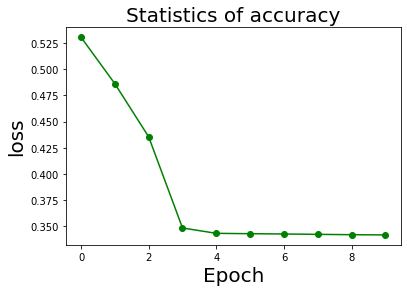

In [34]:
plt.plot(loss_record, 'g-o')
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

## 在验证集验证模型效果

In [35]:
# Get the test.

correct = 0
pred = []

for xx, yy in zip(X_test, y_test):
    data = Tensor(xx, DTYPE)
    label = Tensor([yy], ms.int32)
    circuit.set_encoder_value(data)
    (loss, prob), grads = grad_fn(label)
    ypred = np.argmax(prob[0].numpy())
    pred.append(ypred)

pred = np.array(pred)
print(f"Predict: {pred[:10]}")
print(f"Label:   {y_test[:10]}")

print("Test dataset ACC:", (pred == y_test).sum() / len(X_test))

Predict: [0 1 0 1 1 1 0 1 1 1]
Label:   [0 1 0 1 1 1 0 1 1 1]
Test dataset ACC: 1.0
